In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
#from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

# Preprocessing
- download the 256_objectcategories.tar from [here](https://data.caltech.edu/records/nyy15-4j048)
- untar it into `data/`
- run below script

In [20]:
%%writefile preprocess.py
import os
import shutil
from pathlib import Path

# Animal categories of interest
animals = [
    'bear', 'chimp', 'giraffe', 'gorilla', 'llama',
    'ostrich', 'porcupine', 'skunk', 'triceratops', 'zebra'
]

# Paths
base_dir = Path(__file__).parent
data_dir = base_dir / 'data'
output_dir = base_dir / 'caltech_10'
splits = ['train', 'valid', 'test']

# Ensure output folders exist
for split in splits:
    for animal in animals:
        (output_dir / split / animal).mkdir(parents=True, exist_ok=True)

# Go through each folder in data/
for folder in data_dir.iterdir():
    if not folder.is_dir():
        continue

    for animal in animals:
        if f".{animal}" in folder.name:  # match e.g. "009.bear"
            image_paths = sorted(folder.glob("*.jpg"))
            total = len(image_paths)

            if total < 70:
                print(f"Warning: Not enough images for '{animal}' in {folder.name}. Found {total}. Skipping...")
                continue

            # Split the images
            train_imgs = image_paths[:60]
            valid_imgs = image_paths[60:70]
            test_imgs = image_paths[70:]

            # Move images to respective folders
            for img in train_imgs:
                shutil.move(str(img), output_dir / 'train' / animal / img.name)
            for img in valid_imgs:
                shutil.move(str(img), output_dir / 'valid' / animal / img.name)
            for img in test_imgs:
                shutil.move(str(img), output_dir / 'test' / animal / img.name)

            print(f"Moved {len(train_imgs)} train, {len(valid_imgs)} valid, {len(test_imgs)} test images for '{animal}'.")
            break  # Once matched, no need to check other animals for this folder

print("All done.")


Overwriting preprocess.py


In [21]:
!python preprocess.py

Moved 60 train, 10 valid, 39 test images for 'ostrich'.
Moved 60 train, 10 valid, 32 test images for 'bear'.
Moved 60 train, 10 valid, 40 test images for 'chimp'.
Moved 60 train, 10 valid, 14 test images for 'giraffe'.
Moved 60 train, 10 valid, 31 test images for 'porcupine'.
Moved 60 train, 10 valid, 11 test images for 'skunk'.
Moved 60 train, 10 valid, 142 test images for 'gorilla'.
Moved 60 train, 10 valid, 26 test images for 'zebra'.
Moved 60 train, 10 valid, 25 test images for 'triceratops'.
Moved 60 train, 10 valid, 49 test images for 'llama'.
All done.


# Training

In [22]:
# defining transforms
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [23]:
dataset = 'caltech_10'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

10
{0: 'bear', 1: 'chimp', 2: 'giraffe', 3: 'gorilla', 4: 'llama', 5: 'ostrich', 6: 'porcupine', 7: 'skunk', 8: 'triceratops', 9: 'zebra'}


In [24]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

print(train_data_size, valid_data_size, test_data_size)

600 100 409


In [26]:
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

/opt/anaconda3/envs/metal/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/metal/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/kyo/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


In [27]:
for param in resnet50.parameters():
    param.requires_grad = False

In [28]:
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)



# Convert model to be used on GPU
resnet50 = resnet50.to(device)

In [29]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [30]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history, best_epoch

In [31]:
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 10 epochs
num_epochs = 10
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/10
Epoch : 000, Training: Loss - 1.5433, Accuracy - 53.6667%, 
		Validation : Loss - 0.5858, Accuracy - 84.0000%, Time: 14.8172s
Epoch: 2/10
Epoch : 001, Training: Loss - 0.5580, Accuracy - 85.8333%, 
		Validation : Loss - 0.3362, Accuracy - 92.0000%, Time: 7.6455s
Epoch: 3/10
Epoch : 002, Training: Loss - 0.3041, Accuracy - 92.5000%, 
		Validation : Loss - 0.1941, Accuracy - 96.0000%, Time: 7.7583s
Epoch: 4/10
Epoch : 003, Training: Loss - 0.2085, Accuracy - 94.1667%, 
		Validation : Loss - 0.2163, Accuracy - 92.0000%, Time: 7.9557s
Epoch: 5/10
Epoch : 004, Training: Loss - 0.2196, Accuracy - 94.3333%, 
		Validation : Loss - 0.1889, Accuracy - 95.0000%, Time: 7.8722s
Epoch: 6/10
Epoch : 005, Training: Loss - 0.1579, Accuracy - 96.3333%, 
		Validation : Loss - 0.1433, Accuracy - 97.0000%, Time: 7.8931s
Epoch: 7/10
Epoch : 006, Training: Loss - 0.1159, Accuracy - 97.0000%, 
		Validation : Loss - 0.1339, Accuracy - 97.0000%, Time: 7.9540s
Epoch: 8/10
Epoch : 007, Training: Loss 

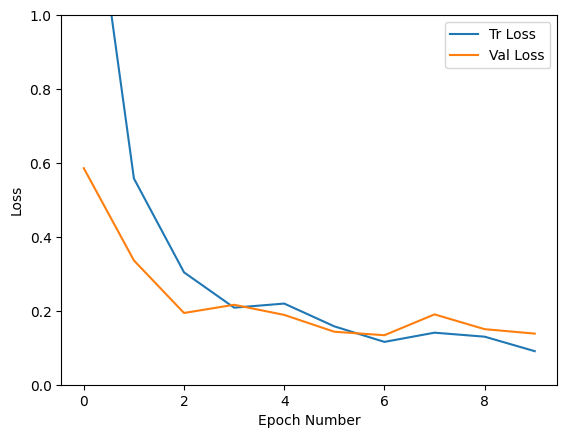

In [32]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

In [33]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
            # Find average test loss and test accuracy
            avg_test_loss = test_loss/test_data_size 
            avg_test_acc = test_acc/test_data_size
            print("Test accuracy : " + str(avg_test_acc))

In [40]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    test_image_tensor = test_image_tensor.view(1, 3, 224, 224).to(device)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(3, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(3):
            print("Prediction", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

Prediction 1 : giraffe , Score:  0.9966916
Prediction 2 : zebra , Score:  0.0026199
Prediction 3 : bear , Score:  0.00025017493


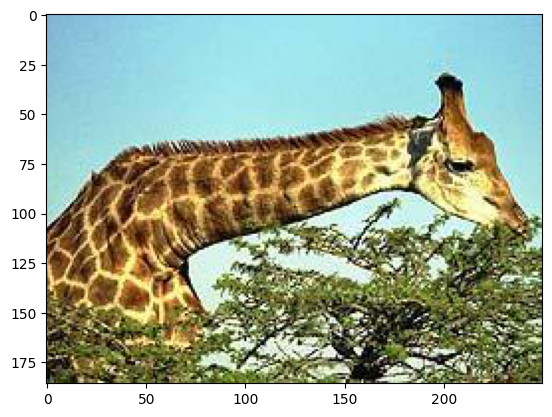

In [44]:
dataset = 'caltech_10'
model = torch.load("{}_model_{}.pt".format(dataset, best_epoch), weights_only=False)
predict(model, './giraffe.jpg')  

Prediction 1 : gorilla , Score:  0.9837143
Prediction 2 : chimp , Score:  0.014099402
Prediction 3 : triceratops , Score:  0.00058499724


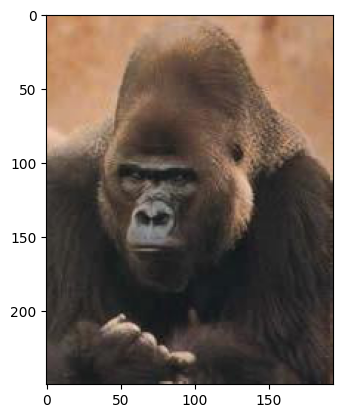

In [46]:
predict(model, './gorilla.jpg')

Prediction 1 : bear , Score:  0.99396086
Prediction 2 : llama , Score:  0.0039283433
Prediction 3 : gorilla , Score:  0.0006130953


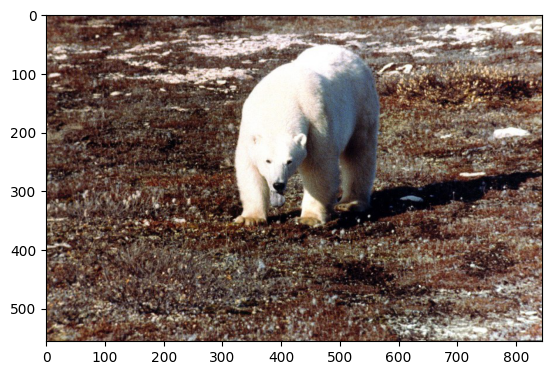

In [47]:
predict(model, './bear.jpg') 

In [48]:
computeTestSetAccuracy(model, loss_func)

Test Batch number: 000, Test: Loss: 0.1226, Accuracy: 0.9688
Test accuracy : 0.07579462102689487
Test Batch number: 001, Test: Loss: 0.2626, Accuracy: 0.9062
Test accuracy : 0.1466992665036675
Test Batch number: 002, Test: Loss: 0.1666, Accuracy: 0.9688
Test accuracy : 0.22249388753056235
Test Batch number: 003, Test: Loss: 0.2123, Accuracy: 0.9375
Test accuracy : 0.29584352078239606
Test Batch number: 004, Test: Loss: 0.2472, Accuracy: 0.8750
Test accuracy : 0.3643031784841076
Test Batch number: 005, Test: Loss: 0.1468, Accuracy: 0.9688
Test accuracy : 0.4400977995110024
Test Batch number: 006, Test: Loss: 0.1873, Accuracy: 0.9375
Test accuracy : 0.5134474327628362
Test Batch number: 007, Test: Loss: 0.2239, Accuracy: 0.9375
Test accuracy : 0.58679706601467
Test Batch number: 008, Test: Loss: 0.1964, Accuracy: 0.9062
Test accuracy : 0.6577017114914425
Test Batch number: 009, Test: Loss: 0.1756, Accuracy: 0.9375
Test accuracy : 0.7310513447432763
Test Batch number: 010, Test: Loss: 0.2